In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import datetime

In [ ]:
# 不想訓練，可以直接到最下面load model

In [154]:
# 導入資料，適用於有digitize字樣的資料(有用帶sec字樣的資料，要改model)
data = pd.read_csv("dataset/testset_digitize_acc2.csv")
data.head()

,gender,points,badges_cnt,user_grade,user_city,has_teacher_cnt,is_self_coach,has_student_cnt,belongs_to_class_cnt,has_class_cnt,total_sec_taken,is_correct
0,no_value,18300,1,1,kh,0,0,0,0,0,37.842105,1
1,no_value,6468,0,1,ntpc,1,0,0,1,0,31.583333,1
2,male,4703,0,1,tp,0,0,0,0,0,19.428571,1
3,no_value,15525,1,2,ntpc,0,0,0,0,0,21.826667,1
4,no_value,7945,0,2,km,1,0,0,1,0,76.500000,1


In [16]:
# 拆分資料集 81%訓練 9%驗證 10%測試
train, test = train_test_split(data, test_size=0.1)
train, val = train_test_split(train, test_size=0.1)

In [17]:
# 設定資料集，轉換成tf.data.Dataset
def df_to_dataset(dataframe, shuffle=True, batch_size=32):

    dataframe = dataframe.copy()

    labels = dataframe.pop("is_correct")

    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))

    if shuffle:

        ds = ds.shuffle(buffer_size=len(dataframe))

    ds = ds.batch(batch_size=batch_size)

    return ds

In [18]:
# 設定資料集(tf.data.Dataset)
batch_size = 64
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [19]:
# 純數字的輸入層
def get_normalization_layer(name, dataset):
    normalizer = layers.Normalization(axis=None)
    feature_ds = dataset.map(lambda x, y: x[name])
    normalizer.adapt(feature_ds)
    return normalizer

In [21]:
# 類別的輸入層(像年級、有無特殊屬性的布林值)
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    if dtype == 'string':
        index = layers.StringLookup(max_tokens=max_tokens)
    else:
        index = layers.IntegerLookup(max_tokens=max_tokens)
    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = layers.CategoryEncoding(num_tokens=index.vocabulary_size())
    embedding = layers.Embedding(index.vocabulary_size(), 4)
    mask = layers.GlobalMaxPool1D()
    return lambda feature: mask(embedding(encoder(index(feature))))

In [22]:
# 設定純數字的輸入層，要加sec要改這裡(加入"total_sec_taken"到for迴圈的list)
all_input = []
encoded_features = []

for header in [
    "points",
    "badges_cnt",
    "has_teacher_cnt",
    "has_student_cnt",
    "belongs_to_class_cnt",
    "has_class_cnt",
    #"total_sec_taken",
]:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_input.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [23]:
# 設定數字類別的輸入層
for header in ['user_grade', 'is_self_coach']:
    grade = tf.keras.Input(shape=(1,), name=header, dtype='int64')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='int64', max_tokens=12)
    encoded_grade = encoding_layer(grade)
    all_input.append(grade)
    encoded_features.append(encoded_grade)

In [24]:
# 設定文字類別的輸入層
category_cols = ["user_city", "gender"]
for header in category_cols:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string', max_tokens=30)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_input.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [25]:
# 設定 Model 的 hidden layers
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(32, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation="relu")(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(2, activation="sigmoid")(x)

In [26]:
model = tf.keras.Model(all_input, output)

In [27]:
# 設定 Model 的 optimizer, loss function, metrics
model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=['accuracy'])

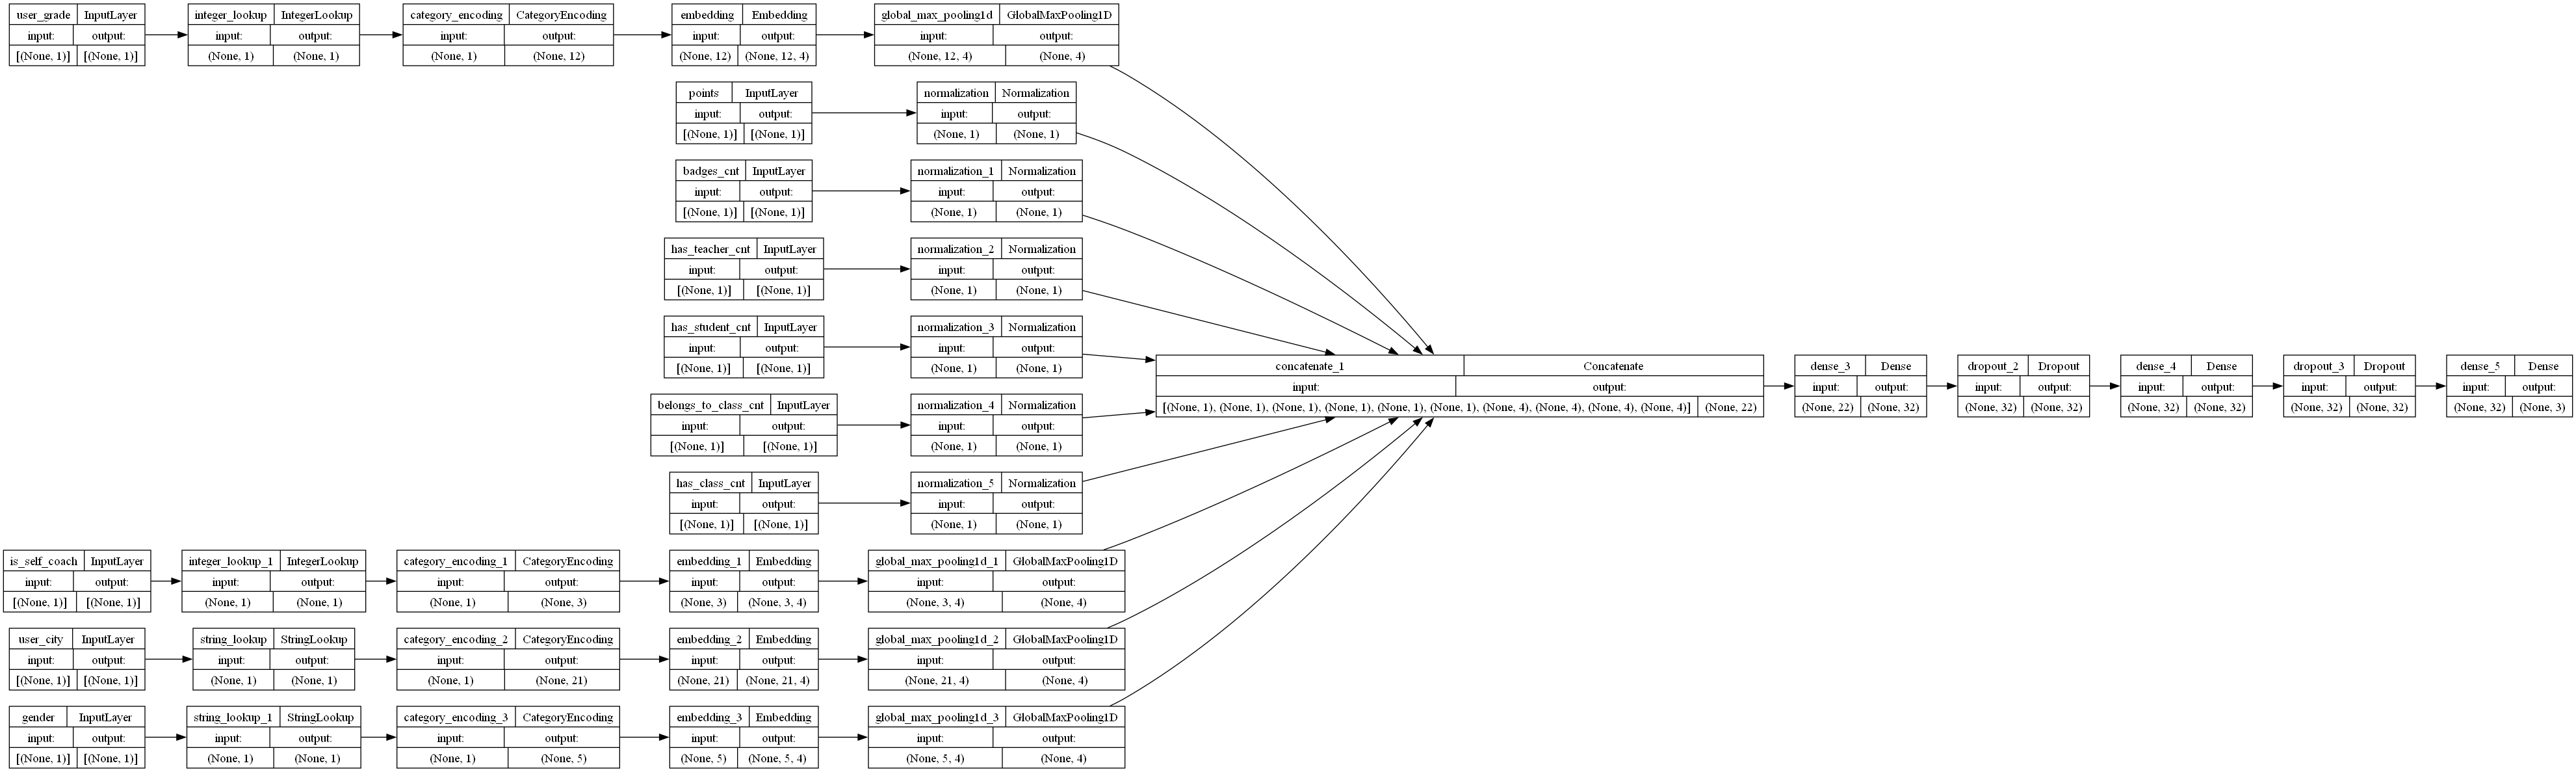

In [19]:
# 顯示 Model 的架構
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [28]:
# 設定 tensorboard(訓練的log)
log_dir = "logs/dataset_fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [29]:
# 訓練 Model
model.fit(train_ds, epochs=300, validation_data=val_ds, callbacks=[tensorboard_callback])

Epoch 1/300

921/921 [==============================] - 10s 4ms/step - loss: 0.3822 - accuracy: 0.8551 - val_loss: 0.3353 - val_accuracy: 0.8627
Epoch 2/300
921/921 [==============================] - 3s 3ms/step - loss: 0.3474 - accuracy: 0.8587 - val_loss: 0.3293 - val_accuracy: 0.8658
Epoch 3/300
921/921 [==============================] - 3s 3ms/step - loss: 0.3401 - accuracy: 0.8597 - val_loss: 0.3255 - val_accuracy: 0.8664
Epoch 4/300
921/921 [==============================] - 3s 3ms/step - loss: 0.3339 - accuracy: 0.8617 - val_loss: 0.3199 - val_accuracy: 0.8696
Epoch 5/300
921/921 [==============================] - 3s 3ms/step - loss: 0.3294 - accuracy: 0.8631 - val_loss: 0.3174 - val_accuracy: 0.8684
Epoch 6/300
921/921 [==============================] - 3s 3ms/step - loss: 0.3266 - accuracy: 0.8643 - val_loss: 0.3122 - val_accuracy: 0.8727
Epoch 7/300
921/921 [==============================] - 3s 3ms/step - loss: 0.3241 - accuracy: 0.8648 - val_loss: 0.3130 - val_accuracy: 0.87

In [30]:
# 用 test 資料集評估 Model
loss, accuracy = model.evaluate(test_ds)

  1/114 [..............................] - ETA: 2s - loss: 0.4282 - accuracy: 0.8438

114/114 [==============================] - 0s 2ms/step - loss: 0.2951 - accuracy: 0.8825


In [157]:
# 儲存 Model
# model.save("model-acc2-sec", save_format="tf")

In [3]:
# 載入 Model(不適用於有 "total_sec_taken" 的資料)
# model = tf.keras.models.load_model("model-acc3")

In [155]:
# 用 test 資料集評估載入的 Model
# model.evaluate(test_ds)

In [4]:
# ans = 0.894737
sample = {
    "gender": "no_value",
    "points": 18300,
    "badges_cnt": 0,
    "user_grade": 1,
    "user_city": "kh",
    "has_teacher_cnt": 0,
    "is_self_coach": 0,
    "has_student_cnt": 0,
    "belongs_to_class_cnt": 0,
    "has_class_cnt": 0,
    #"total_sec_taken": 37.842105,
}

In [110]:
sample2={
    'gender': "male",       #用[UNK]與其他值測過，結果一樣
    'points': 9075,         #*對結果有影響，正相關
    'badges_cnt': 9,        #*對結果有影響，負相關
    'user_grade': 7,        #用-1測過，結果一樣
    'user_city': "kh",      #用[UNK]測過，結果一樣
    'has_teacher_cnt': 3,   #*對結果有影響，負相關
    'is_self_coach': 0,     #用-1測過，結果一樣
    'has_student_cnt': 0,   #*對結果有影響，正相關
    'belongs_to_class_cnt':3,  #*對結果有影響，先降後升
    'has_class_cnt': 0,    #*對結果有影響，先降後升
    #'total_sec_taken': 14,
}

In [5]:
# 預測單筆資料
input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
pred = model.predict(input_dict)
print(pred)

1/1 [==============================] - 0s 295ms/step
[[0.08475275 0.40798438 0.9253101 ]]
